In [1]:
import torch

/Users/sangje/miniforge3/envs/sslsv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
import pytorch_lightning as ln

In [13]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl

# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))


# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [14]:
# setup data
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 20723281.88it/s]


Extracting /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw/train-images-idx3-ubyte.gz to /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 22453326.01it/s]

Extracting /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 6985050.38it/s]


Extracting /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 13559095.21it/s]

Extracting /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/sangje/My_workplace/Audio/SpeakerVerification/sv_frame/MNIST/raw



In [112]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = pl.Trainer(limit_train_batches=100, max_epochs=300)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 299: 100%|███████| 100/100 [00:00<00:00, 360.33it/s, loss=0.0167, v_num=4]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|███████| 100/100 [00:00<00:00, 356.49it/s, loss=0.0167, v_num=4]


In [122]:
# load checkpoint
checkpoint = "./lightning_logs/version_4/checkpoints/epoch=299-step=30000.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
decoder = autoencoder.decoder
encoder.eval()
decoder.eval()

# embed 4 fake images!
fake_image_batch = dataset[2][0].squeeze().reshape(28*28)

embeddings = encoder(fake_image_batch)
fake_images = decoder(embeddings)
print("⚡" * 20, "\nPredictions (image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (image embeddings):
 tensor([-1.8607, -1.1584, -0.9053], grad_fn=<AddBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


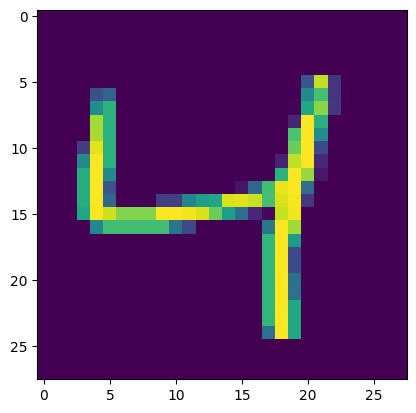

In [123]:
plt.imshow(dataset[2][0].squeeze().detach().numpy())

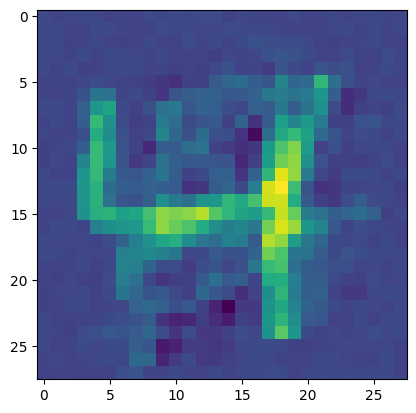

In [124]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(fake_images.reshape(28,28).detach().numpy())